In [1]:
%matplotlib inline
import numpy as np
from scipy import signal
from matplotlib import cm, colorbar
import matplotlib.pyplot as plt
import skimage as ski
from skimage import io, data, color, filters, feature, transform, exposure

## Image Gradient Vector

First of all, I would like to make sure we can distinguish the following terms. They are very similar, closely related, but not exactly the same. The rate of change of a function $f(x,y,z,...)$ at a point $(x_0,y_0,z_0,...)$, which is the slope of the tangent line at the point. The instantaneous rate of change of $f(x,y,z, ...)$ in the direction of an unit vector $\vec{u}$. It points in the direction of the greatest rate of increase of the function, containing all the partial derivative information of a multivariable function.

In the image processing, we want to know the direction of colors changing from one extreme to the other (i.e. black to white on a grayscale image). Therefore, we want to measure "gradient" on pixels of colors. The gradient on an image is discrete because each pixel is independent and cannot be further split.

The [image gradient vector](https://en.wikipedia.org/wiki/Image_gradient) is defined as a metric for every individual pixel, containing the pixel color changes in both x-axis and y-axis. The definition is aligned with the gradient of a continuous multi-variable function, which is a vector of partial derivatives of all the variables. Suppose f(x, y) records the color of the pixel at location (x, y), the gradient vector of the pixel (x, y) is defined as follows:

$$
\begin{align*}
\nabla f(x, y)
= \begin{bmatrix}
  g_x \\
  g_y
\end{bmatrix}
= \begin{bmatrix}
  \frac{\partial f}{\partial x} \\[6pt]
  \frac{\partial f}{\partial y}
\end{bmatrix}
= \begin{bmatrix}
  f(x+1, y) - f(x-1, y)\\
  f(x, y+1) - f(x, y-1)
\end{bmatrix}
\end{align*}
$$

The $\frac{\partial f}{\partial x}$ term is the partial derivative on the x-direction, which is computed as the color difference between the adjacent pixels on the left and right of the target, f(x+1, y) - f(x-1, y). Similarly, the $\frac{\partial f}{\partial y}$ term is the partial derivative on the y-direction, measured as f(x, y+1) - f(x, y-1), the color difference between the adjacent pixels above and below the target.


There are two important attributes of an image gradient:
- **Magnitude** is the L2-norm of the vector, $g = \sqrt{ g_x^2 + g_y^2 }$.
- **Direction** is the arctangent of the ratio between the partial derivatives on two directions, $\theta = \arctan{(g_y / g_x)}$.

![Pixels for Gradient Vector]({{ '/assets/images/image-gradient-vector-pixel-location.png' | relative_url }})
{: style="width: 70%;" class="center"}
*Fig. 1. To compute the gradient vector of a target pixel at location (x, y), we need to know the colors of its four neighbors (or eight surrounding pixels depending on the kernel).*


The gradient vector of the example in Fig. 1. is:

$$
\begin{align*}
\nabla f 
= \begin{bmatrix}
  f(x+1, y) - f(x-1, y)\\
  f(x, y+1) - f(x, y-1)
\end{bmatrix}
= \begin{bmatrix}
  55-105\\
  90-40
\end{bmatrix}
= \begin{bmatrix}
  -50\\
  50
\end{bmatrix}
\end{align*}
$$

Thus,
- the magnitude is $\sqrt{50^2 + (-50)^2} = 70.7107$, and
- the direction is $\arctan{(-50/50)} = -45^{\circ}$.

Repeating the gradient computation process for every pixel iteratively is too slow. Instead, it can be well translated into applying a convolution operator on the entire image matrix, labeled as $\mathbf{A}$ using one of the specially designed convolutional kernels.

Let's start with the x-direction of the example in Fig 1. using the kernel $[-1,0,1]$ sliding over the x-axis; $\ast$ is the convolution operator:

$$
\begin{align*}
\mathbf{G}_x &= 
[-1, 0, 1] \ast [105, 255, 55] = -105 + 0 + 55 = -50
\end{align*}
$$

Similarly, on the y-direction, we adopt the kernel $[+1, 0, -1]^\top$:

$$
\begin{align*}
\mathbf{G}_y &= 
[+1, 0, -1]^\top \ast
\begin{bmatrix}
  90\\
  255\\
  40
\end{bmatrix} 
= 90 + 0 - 40 = 50
\end{align*}
$$

Try this in python:

In [1]:
import numpy as np
import scipy.signal as sig
data = np.array([[0, 105, 0], [40, 255, 90], [0, 55, 0]])
G_x = sig.convolve2d(data, np.array([[-1, 0, 1]]), mode='valid') 
G_y = sig.convolve2d(data, np.array([[-1], [0], [1]]), mode='valid')

These two functions return `array([[0], [-50], [0]])` and `array([[0, 50, 0]])` respectively. (Note that in the numpy array representation, 40 is shown in front of 90, so -1 is listed before 1 in the kernel correspondingly.)

### Common Image Processing Kernels

[Prewitt operator](https://en.wikipedia.org/wiki/Prewitt_operator): Rather than only relying on four directly adjacent neighbors, the Prewitt operator utilizes eight surrounding pixels for smoother results.

$$
\mathbf{G}_x = \begin{bmatrix}
-1 & 0 & +1 \\
-1 & 0 & +1 \\
-1 & 0 & +1
\end{bmatrix} \ast \mathbf{A} \text{ and }
\mathbf{G}_y = \begin{bmatrix}
+1 & +1 & +1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix} \ast \mathbf{A}
$$

[Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator): To emphasize the impact of directly adjacent pixels more, they get assigned with higher weights. 

$$
\mathbf{G}_x = \begin{bmatrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{bmatrix} \ast \mathbf{A} \text{ and }
\mathbf{G}_y = \begin{bmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix} \ast \mathbf{A}
$$

Different kernels are created for different goals, such as edge detection, blurring, sharpening and many more. Check [this wiki page](https://en.wikipedia.org/wiki/Kernel_(image_processing)) for more examples and references.

### Example: Manu in 2004

Let's run a simple experiment on the photo of Manu Ginobili in 2004, when he still had a lot of hair. For simplicity, the photo is converted to grayscale first. For colored images, we just need to repeat the same process in each color channel respectively.

<img src="images/manu-2004.png" width="60%">

Manu Ginobili in 2004 with hair. (Image source: [Manu Ginobili's bald spot through the years](http://ftw.usatoday.com/2013/05/manu-ginobilis-bald-spot-through-the-years))*

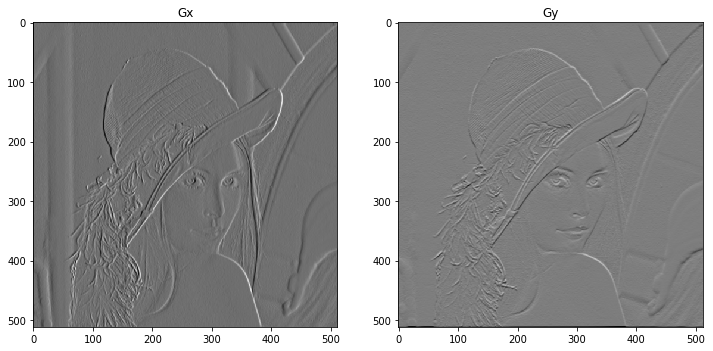

In [19]:
img_c = io.imread('./images/lena.jpg')

img_g = color.rgb2gray(img_c)


# Define the Sobel operator kernels.
kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

G_x = signal.convolve2d(img_g, kernel_x, mode='same') 
G_y = signal.convolve2d(img_g, kernel_y, mode='same') 

# Plot them!
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1, n_ims, n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() # Only place in this blog you can't replace 'gray' with 'grey'
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

show_images(images=[G_x, G_y], titles=["Gx", "Gy"])

<img src="images/manu-2004-sobel-operator.png" width="60%">

Apply Sobel operator kernel on the example image.*


You might notice that most area is in gray. Because the difference between two pixel is between -255 and 255 and we need to convert them back to [0, 255] for the display purpose. A simple linear transformation ($\mathbf{G}$ + 255)/2 would interpret all the zeros (i.e., constant colored background shows no change in gradient) as 125 (shown as gray).

## Image pyramids
<ul>
<li>Image information occurs over many different spatial scales.</li>
<li>Image pyramids - multi-resolution representations for images
are a useful data structure for analyzing and manipulating images
over a range of spatial scales.</li>
</ul>
 
<img src="images/pyramid.png" width="500"/>

##### Multi-Resolution Representations

<ul>
<li>We first blur and subsample the original image by a factor of two and store
this in the next level of the pyramid.</li>
<li>They then subtract this low-pass version from the original to yield the
band-pass Laplacian image.</li>
<li>The pyramid has perfect reconstruction: the Laplacian images plus the
base-level Gaussian are sufficient to exactly reconstruct the original image.</li>
</ul>

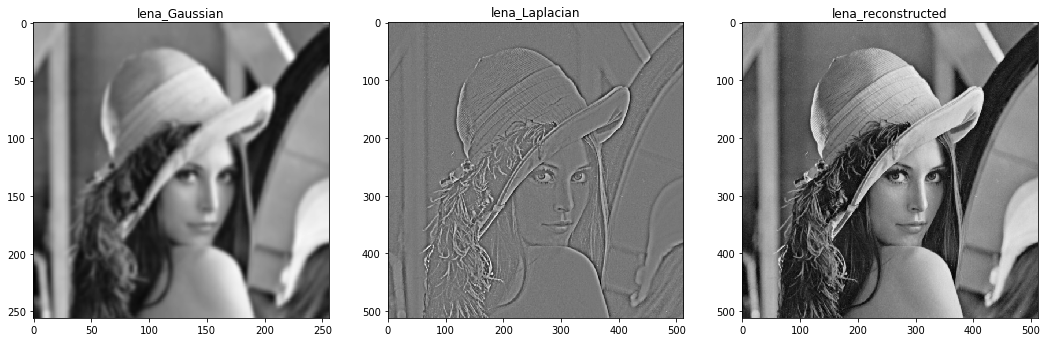

In [23]:
img_p = transform.pyramid_reduce(img_g, sigma=3)

img = transform.pyramid_expand(img_p)

img_l = img_g - img

img_o = img_l + img

show_images(images=[img_p, img_l, img_o], titles=["lena_Gaussian", "lena_Laplacian", "lena_reconstructed"])

# Interest points and corners

Characteristics of good features 

    1. Repeatability
        - The same feature can be found in several images despite geometric and photometric transformations 
    2. Saliency
        - Each feature is distinctive 
    3. Compactness and efficiency
        - Many fewer features than image pixels 
    4. Locality
        - A feature occupies a relatively small area of the image; robust to clutter and occlusion 

Concider shifting a window by $U = (u,v)$ over a image. The auto-correlation function $E(u,v)$ is defined as:

\begin{align*}
E(u,v) &= \sum_{(x,y)\in W} \big[I(x+u,y+v) - I(x,y)\big]^2 \\
&\thickapprox \sum_{(x,y)\in W} \big[I(x,y) + [I_x\;\;I_y] [u\;\; v]^T - I(x,y)^2\big] \\
&\thickapprox \sum_{(x,y)\in W} \big[[I_x\;\;I_y] [u\;\; v]^T\big]^2
\end{align*}

The quadratic approximation simplifies to 
\begin{align*}
E(u,v) \thickapprox [u\;\; v]\;M \;[u\;\; v]^T
\end{align*}

where $M$ is a second moment matrix computed from image derivatives (aka structure tensor):
\begin{align*}
M = \sum_{x,y}
  \begin{bmatrix}
    I_x^2 & I_xI_y \\
    I_xI_y & I_y^2
  \end{bmatrix}
\end{align*}

In practice, using a simple window $W$ does not work too well. Instead, we'll weight each derivatives based on its distance from the center pixel. The surface $E(u,v)$ is locally approximated by a quadratic from
\begin{align*}
E(u,v) \thickapprox [u\;\; v]\;M \;[u\;\; v]^T
\end{align*}

<img src="images/ellipse.png" width="500"/>

This is the equation of an ellipse. Concider a horizontal ''slice'' of $E(u,v)$: $[u\;\; v]\;M \;[u\;\; v]^T=constant$. $M$ can be interpreted as a tensor where the outer product of the gradients are convolved with a weighted function. Eigenvalues a notation of uncertainty. 

<img src="images/eigen.png" width="500"/>

$M$ is symmetric.
\begin{align*}
M = \begin{bmatrix}
    \lambda_0 & 0 \\
    0 & \lambda_1
  \end{bmatrix}
\end{align*}

The eigenvalues of $M$ reveal the amount of intensity change in the two principal orthogonal gradient directions in the window.

<ul>
<li>Shi and Tomasi, $94$ proposed the smallest eigenvalue of $M$, i.e., $\lambda_0^{\frac{-1}{2}}$</li>
<li>Harris and Stephens, $88$ is rotationally invariant and downweights edge-like
features where $\lambda_0 \gg \lambda_1$</li>
\begin{align*}
det(M) - \alpha\; trace(M)^2 = \lambda_0\;\lambda_1 - \alpha(\lambda_0+\lambda_1)^2\\
\end{align*}
<li>Triggs, $04$ suggested</li>
\begin{align*}
\lambda_0 - \alpha\;\lambda_1\\
\end{align*}
also reduces the response at 1D edges, where aliasing errors sometimes
inflate the smaller eigenvalue
<li>Brown et al, $05$ use the harmonic mean</li>
\begin{align*}
\frac{det(M)}{trace(M)} = \frac{\lambda_0\;\lambda_1}{\lambda_0+\lambda_1}\\
\end{align*}
</ul>

<img src="images/corner.png" width="500"/>

<strong>Steps of corner detector:</strong>

<ul>
<li>Image derivatives (optionally, blur first) </li>
<li>Square of derivatives</li>
<li>Cornerness function – both eigenvalues are strong Compute $f$ > threshold</li>
<li>Non-maxima har suppression</li>
</ul>



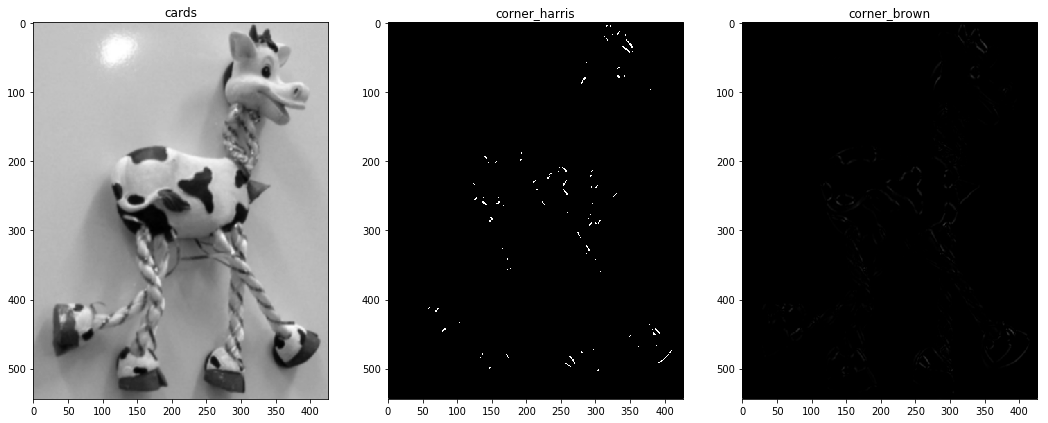

In [24]:
img = io.imread("images/ziraf.png", True)

img = filters.gaussian(img, sigma=1)

kx = [[-1, 0, 1]]
ky = [[-1],[0],[1]]

Ix = signal.convolve2d(img, kx, mode="same")
Iy = signal.convolve2d(img, ky, mode="same")

Ix = Ix ** 2
Iy = Iy ** 2

Ixy = Ix * Iy

trace1 = 0.04 * (Ix + Iy)**2

trace2 = Ix + Iy + 0.004

det = (Ix * Iy) - (Ixy**2)

I1 = det - trace1
I2 = det / trace2

I1 =np.where(I1  < 0.001, 0, 1)

show_images(images=[img, I1, I2], titles=["cards", "corner_harris", "corner_brown"])

## Histogram of Oriented Gradients (HOG)

The Histogram of Oriented Gradients (HOG) is an efficient way to extract features out of the pixel colors for building an object recognition classifier. With the knowledge of image gradient vectors, it is not hard to understand how HOG works. Let's start!


### How HOG works

1) Preprocess the image, including resizing and color normalization.

2) Compute the gradient vector of every pixel, as well as its magnitude and direction.

3) Divide the image into many 8x8 pixel cells. In each cell, the magnitude values of these 64 cells are binned and cumulatively added into 9 buckets of unsigned direction (no sign, so 0-180 degree rather than 0-360 degree; this is a practical choice based on empirical experiments). 
<br/><br/>
For better robustness, if the direction of the gradient vector of a pixel lays between two buckets, its magnitude does not all go into the closer one but proportionally split between two. For example, if a pixel's gradient vector has magnitude 8 and degree 15, it is between two buckets for degree 0 and 20 and we would assign 2 to bucket 0 and 6 to bucket 20. 
<br/><br/>
This interesting configuration makes the histogram much more stable when small distortion is applied to the image.

<img src="images/HOG-histogram-creation.png" width="60%">

How to split one gradient vector's magnitude if its degress is between two degree bins. (Image source: https://www.learnopencv.com/histogram-of-oriented-gradients/)*

4) Then we slide a 2x2 cells (thus 16x16 pixels) block across the image. In each block region, 4 histograms of 4 cells are concatenated into one-dimensional vector of 36 values and then normalized to have an unit weight.
The final HOG feature vector is the concatenation of all the block vectors. It can be fed into a classifier like SVM for learning object recognition tasks.

### Example: Manu in 2004

Let's reuse the same example image in the previous section. Remember that we have computed $\mathbf{G}_x$ and $\mathbf{G}_y$ for the whole image.

In [3]:
N_BUCKETS = 9
CELL_SIZE = 8  # Each cell is 8x8 pixels
BLOCK_SIZE = 2  # Each block is 2x2 cells

def assign_bucket_vals(m, d, bucket_vals):
    left_bin = int(d / 20.)
    # Handle the case when the direction is between [160, 180)
    right_bin = (int(d / 20.) + 1) % N_BUCKETS
    assert 0 <= left_bin < right_bin < N_BUCKETS

    left_val= m * (right_bin * 20 - d) / 20
    right_val = m * (d - left_bin * 20) / 20
    bucket_vals[left_bin] += left_val
    bucket_vals[right_bin] += right_val

def get_magnitude_hist_cell(loc_x, loc_y):
    # (loc_x, loc_y) defines the top left corner of the target cell.
    cell_x = G_x[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    cell_y = G_y[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    magnitudes = np.sqrt(cell_x * cell_x + cell_y * cell_y)
    directions = np.abs(np.arctan(cell_y / cell_x) * 180 / np.pi)

    buckets = np.linspace(0, 180, N_BUCKETS + 1)
    bucket_vals = np.zeros(N_BUCKETS)
    map(
        lambda (m, d): assign_bucket_vals(m, d, bucket_vals), 
        zip(magnitudes.flatten(), directions.flatten())
    )
    return bucket_vals

def get_magnitude_hist_block(loc_x, loc_y):
    # (loc_x, loc_y) defines the top left corner of the target block.
    return reduce(
        lambda arr1, arr2: np.concatenate((arr1, arr2)),
        [get_magnitude_hist_cell(x, y) for x, y in zip(
            [loc_x, loc_x + CELL_SIZE, loc_x, loc_x + CELL_SIZE],
            [loc_y, loc_y, loc_y + CELL_SIZE, loc_y + CELL_SIZE],
        )]
    )

SyntaxError: invalid syntax (<ipython-input-3-0445682cd938>, line 26)

The following code simply calls the functions to construct a histogram and plot it.

In [4]:
# Random location [200, 200] as an example.
loc_x = loc_y = 200

ydata = get_magnitude_hist_block(loc_x, loc_y)
ydata = ydata / np.linalg.norm(ydata)

xdata = range(len(ydata))
bucket_names = np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)

assert len(ydata) == N_BUCKETS * (BLOCK_SIZE * BLOCK_SIZE)
assert len(bucket_names) == len(ydata)

plt.figure(figsize=(10, 3))
plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
plt.xticks(xdata, bucket_names * 20, rotation=90)
plt.xlabel('Direction buckets')
plt.ylabel('Magnitude')
plt.grid(ls='--', color='k', alpha=0.1)
plt.title("HOG of block at [%d, %d]" % (loc_x, loc_y))
plt.tight_layout()

NameError: name 'get_magnitude_hist_block' is not defined

In the code above, I use the block with top left corner located at [200, 200] as an example and here is the final normalized histogram of this block. You can play with the code to change the block location to be identified by a sliding window.

<img src="images/block_histogram.png" width="60%">

Demonstration of a HOG histogram for one block.*


The code is mostly for demonstrating the computation process. There are many off-the-shelf libraries with HOG algorithm implemented, such as [OpenCV](https://github.com/opencv/opencv), [SimpleCV](http://simplecv.org/) and [scikit-image](http://scikit-image.org/).


## Image Segmentation (Felzenszwalb's Algorithm)

When there exist multiple objects in one image (true for almost every real-world photos), we need to identify a region that potentially contains a target object so that the classification can be executed more efficiently. 

Felzenszwalb and Huttenlocher ([2004](http://cvcl.mit.edu/SUNSeminar/Felzenszwalb_IJCV04.pdf)) proposed an algorithm for segmenting an image into similar regions using a graph-based approach. It is also the initialization method for Selective Search (a popular region proposal algorithm) that we are gonna discuss later.

Say, we use a undirected graph $G=(V, E)$ to represent an input image. One vertex $v_i \in V$ represents one pixel. One edge $e = (v_i, v_j) \in E$ connects two vertices $v_i$ and $v_j$. Its associated weight $w(v_i, v_j)$ measures the dissimilarity between $v_i$ and $v_j$. The dissimilarity can be quantified in dimensions like color, location, intensity, etc. The higher the weight, the less similar two pixels are. A segmentation solution $S$ is a partition of $V$ into multiple connected components, $\{C\}$. Intuitively similar pixels should belong to the same components while dissimilar ones are assigned to different components.


### Graph Construction

There are two approaches to constructing a graph out of an image.
- **Grid Graph**: Each pixel is only connected with surrounding neighbours (8 other cells in total). The edge weight is the absolute difference between the intensity values of the pixels.
- **Nearest Neighbor Graph**: Each pixel is a point in the feature space (x, y, r, g, b), in which (x, y) is the pixel location and (r, g, b) is the color values in RGB. The weight is the Euclidean distance between two pixels' feature vectors.


### Key Concepts

Before we lay down the criteria for a good graph partition (aka image segmentation), let us define a couple of key concepts:
- **Internal difference**: $Int(C) = \max_{e\in MST(C, E)} w(e)$, where $MST$ is the minimum spanning tree of the components. A component $C$ can still remain connected even when we have removed all the edges with weights < $Int(C)$.
- **Difference between two components**: $Dif(C_1, C_2) = \min_{v_i \in C_1, v_j \in C_2, (v_i, v_j) \in E} w(v_i, v_j)$. $Dif(C_1, C_2) = \infty$ if there is no edge in-between.
- **Minimum internal difference**: $MInt(C_1, C_2) = min(Int(C_1) + \tau(C_1), Int(C_2) + \tau(C_2))$, where $\tau(C) = k / \vert C \vert$ helps make sure we have a meaningful threshold for the difference between components. With a higher $k$, it is more likely to result in larger components. 

The quality of a segmentation is assessed by a pairwise region comparison predicate defined for given two regions $C_1$ and $C_2$:

$$
D(C_1, C_2) = 
\begin{cases}
  \text{True} & \text{ if } Dif(C_1, C_2) > MInt(C_1, C_2) \\
  \text{False} & \text{ otherwise}
\end{cases}
$$

Only when the predicate holds True, we consider them as two independent components; otherwise the segmentation is too fine and they probably should be merged.


### How Image Segmentation Works

The algorithm follows a bottom-up procedure. Given $G=(V, E)$ and $|V|=n, |E|=m$:
1. Edges are sorted by weight in ascending order, labeled as $e_1, e_2, \dots, e_m$.
2. Initially, each pixel stays in its own component, so we start with $n$ components.
3. Repeat for $k=1, \dots, m$:
    * The segmentation snapshot at the step $k$ is denoted as $S^k$.
    * We take  the k-th edge in the order, $e_k = (v_i, v_j)$. 
    * If $v_i$ and $v_j$ belong to the same component, do nothing and thus $S^k = S^{k-1}$.
    * If $v_i$ and $v_j$ belong to two different components $C_i^{k-1}$ and $C_j^{k-1}$ as in the segmentation $S^{k-1}$, we want to merge them into one if $w(v_i, v_j) \leq MInt(C_i^{k-1}, C_j^{k-1})$; otherwise do nothing.

If you are interested in the proof of the segmentation properties and why it always exists, please refer to the [paper](http://fcv2011.ulsan.ac.kr/files/announcement/413/IJCV(2004)%20Efficient%20Graph-Based%20Image%20Segmentation.pdf).

<img src="images/image-segmentation-indoor.png" width="60%">

An indoor scene with segmentation detected by the grid graph construction in Felzenszwalb's graph-based segmentation algorithm (k=300).*


### Example: Manu in 2013

This time I would use the photo of old Manu Ginobili in 2013, as the example image when his bald spot has grown up strong. Still for simplicity, we use the picture in grayscale.

<img src="images/manu-2013.png" width="60%">

Manu Ginobili in 2013 with bald spot. (Image source: [Manu Ginobili's bald spot through the years](http://ftw.usatoday.com/2013/05/manu-ginobilis-bald-spot-through-the-years))*


Rather than coding from scratch, let us apply [skimage.segmentation.felzenszwalb](http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb) to the image.

In [5]:
import skimage.segmentation
from matplotlib import pyplot as plt

img2 = scipy.misc.imread("manu-2013.jpg", mode="L")
segment_mask1 = skimage.segmentation.felzenszwalb(img2, scale=100)
segment_mask2 = skimage.segmentation.felzenszwalb(img2, scale=1000)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(segment_mask1); ax1.set_xlabel("k=100")
ax2.imshow(segment_mask2); ax2.set_xlabel("k=1000")
fig.suptitle("Felsenszwalb's efficient graph based image segmentation")
plt.tight_layout()
plt.show()

/Users/newscred/.local/share/virtualenvs/NeuralNetwork-Db90wnYD/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


FileNotFoundError: [Errno 2] No such file or directory: 'manu-2013.jpg'

The code ran two versions of Felzenszwalb's algorithms as shown in Fig. 8. The left k=100 generates a finer-grained segmentation with small regions where Manu's bald spot is identified. The right one k=1000 outputs a coarser-grained segmentation where regions tend to be larger.

<img src="images/manu-2013-segmentation.png" width="60%">

Felsenszwalb's efficient graph-based image segmentation is applied on the photo of Manu in 2013.*

## Selective Search

Selective search is a common algorithm to provide region proposals that potentially contain objects. It is built on top of the image segmentation output and use region-based characteristics (NOTE: not just attributes of a single pixel) to do a bottom-up hierarchical grouping.


### How Selective Search Works

1. At the initialization stage, apply Felzenszwalb and Huttenlocher's graph-based image segmentation algorithm to create regions to start with. 
2. Use a greedy algorithm to iteratively group regions together: 
    * First the similarities between all neighbouring regions are calculated.
    * The two most similar regions are grouped together, and new similarities are calculated between the resulting region and its neighbours. 
3. The process of grouping the most similar regions (Step 2) is repeated until the whole image becomes a single region. 

<img src="images/selective-search-algorithm.png" width="60%">

The detailed algorithm of Selective Search.*


### Configuration Variations

Given two regions $(r_i, r_j)$, selective search proposed four complementary similarity measures:
- **Color** similarity
- **Texture**: Use algorithm that works well for material recognition such as [SIFT](http://www.cs.ubc.ca/~lowe/papers/iccv99.pdf).
- **Size**: Small regions are encouraged to merge early.
- **Shape**: Ideally one region can fill the gap of the other. 

By (i) tuning the threshold $k$ in Felzenszwalb and Huttenlocher's algorithm, (ii) changing the color space and (iii) picking different combinations of similarity metrics, we can produce a diverse set of Selective Search strategies. The version that produces the region proposals with best quality is configured with (i) a mixture of various initial segmentation proposals, (ii) a blend of multiple color spaces and (iii) a combination of all similarity measures. Unsurprisingly we need to balance between the quality (the model complexity) and the speed.


## Evaluation Metrics: mAP

A common evaluation metric used in many object recognition and detection tasks is "**mAP**", short for "**mean average precision**". It is a number from 0 to 100; higher value is better.
- Combine all detections from all test images to draw a precision-recall curve (PR curve) for each class; The "average precision" (AP) is the area under the PR curve.
- Given that target objects are in different classes, we first compute AP separately for each class, and then average over classes.
- A detection is a true positive if it has **"intersection over union" (IoU)** with a ground-truth box greater than some threshold (usually 0.5; if so, the metric is "mAP@0.5")

## Deformable Parts Model

The Deformable Parts Model (DPM) ([Felzenszwalb et al., 2010](http://people.cs.uchicago.edu/~pff/papers/lsvm-pami.pdf)) recognizes objects with a mixture graphical model (Markov random fields) of deformable parts. The model consists of three major components:
1. A coarse ___root filter___ defines a detection window that approximately covers an entire object. A filter specifies weights for a region feature vector.
2. Multiple ___part filters___ that cover smaller parts of the object. Parts filters are learned at twice resolution of the root filter.
3. A ___spatial model___ for scoring the locations of part filters relative to the root.

<img src="images/DPM.png" width="60%">

The DPM model contains (a) a root filter, (b) multiple part filters at twice the resolution, and (c) a model for scoring the location and deformation of parts.*


The quality of detecting an object is measured by the score of filters minus the deformation costs. The matching score $f$, in laymen's terms, is:

$$
f(\text{model}, x) = f(\beta_\text{root}, x) + \sum_{\beta_\text{part} \in \text{part filters}} \max_y [f(\beta_\text{part}, y) - \text{cost}(\beta_\text{part}, x, y)]
$$

in which,
- $x$ is an image with a specified position and scale;
- $y$ is a sub region of $x$.
- $\beta_\text{root}$ is the root filter.
- $\beta_\text{part}$ is one part filter.
- cost() measures the penalty of the part deviating from its ideal location relative to the root.


The basic score model is the dot product between the filter $\beta$ and the region feature vector $\Phi(x)$: $f(\beta, x) = \beta \cdot \Phi(x)$. The feature set $\Phi(x)$ can be defined by HOG or other similar algorithms.


A root location with high score detects a region with high chances to contain an object, while the locations of the parts with high scores confirm a recognized object hypothesis. The paper adopted latent SVM to model the classifier.

<img src="images/DPM-matching.png" width="60%">

The matching process by DPM. (Image source: [Felzenszwalb et al., 2010](http://people.cs.uchicago.edu/~pff/papers/lsvm-pami.pdf))*


The author later claimed that DPM and CNN models are not two distinct approaches to object recognition. Instead, a DPM model can be formulated as a CNN by unrolling the DPM inference algorithm and mapping each step to an equivalent CNN layer. (Check the details in [Girshick et al., 2015](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Girshick_Deformable_Part_Models_2015_CVPR_paper.pdf)!)

## Overfeat

Overfeat [[paper](https://pdfs.semanticscholar.org/f2c2/fbc35d0541571f54790851de9fcd1adde085.pdf)][[code](https://github.com/sermanet/OverFeat)] is a pioneer model of integrating the object detection, localization and classification tasks all into one convolutional neural network. The main idea is to (i) do image classification at different locations on regions of multiple scales of the image in a sliding window fashion, and (ii) predict the bounding box locations with a regressor trained on top of the same convolution layers.

The Overfeat model architecture is very similar to [AlexNet](#alexnet-krizhevsky-et-al-2012). It is trained as follows:

<img src="images/overfeat-training.png" width="60%">

The training stages of the Overfeat model. (Image source: [link](http://vision.stanford.edu/teaching/cs231b_spring1415/slides/overfeat_eric.pdf))*


1. Train a CNN model (similar to AlexNet) on the image classification task.
2. Then, we replace the top classifier layers by a regression network and train it to predict object bounding boxes at each spatial location and scale. The regressor is class-specific, each generated for one image class.
	- Input: Images with classification and bounding box.
	- Output: $(x_\text{left}, x_\text{right}, y_\text{top}, y_\text{bottom})$, 4 values in total, representing the coordinates of the bounding box edges.
	- Loss: The regressor is trained to minimize $l2$ norm between generated bounding box and the ground truth for each training example.


At the detection time,
1. Perform classification at each location using the pretrained CNN model.
2. Predict object bounding boxes on all classified regions generated by the classifier.
3. Merge bounding boxes with sufficient overlap from localization and sufficient confidence of being the same object from the classifier.

## Reference

[1] Dalal, Navneet, and Bill Triggs. ["Histograms of oriented gradients for human detection."](https://hal.inria.fr/file/index/docid/548512/filename/hog_cvpr2005.pdf) Computer Vision and Pattern Recognition (CVPR), 2005.

[2] Pedro F. Felzenszwalb, and Daniel P. Huttenlocher. ["Efficient graph-based image segmentation."](http://cvcl.mit.edu/SUNSeminar/Felzenszwalb_IJCV04.pdf) Intl. journal of computer vision 59.2 (2004): 167-181.

[3] [Histogram of Oriented Gradients by Satya Mallick](https://www.learnopencv.com/histogram-of-oriented-gradients/)

[4] [Gradient Vectors by Chris McCormick](http://mccormickml.com/2013/05/07/gradient-vectors/)

[5] [HOG Person Detector Tutorial by Chris McCormick](http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/)

[1] Vincent Dumoulin and Francesco Visin. ["A guide to convolution arithmetic for deep learning."](https://arxiv.org/pdf/1603.07285.pdf) arXiv preprint arXiv:1603.07285 (2016).

[2] Haohan Wang, Bhiksha Raj, and Eric P. Xing. ["On the Origin of Deep Learning."](https://arxiv.org/pdf/1702.07800.pdf) arXiv preprint arXiv:1702.07800 (2017).

[3] Pedro F. Felzenszwalb, Ross B. Girshick, David McAllester, and Deva Ramanan. ["Object detection with discriminatively trained part-based models."](http://people.cs.uchicago.edu/~pff/papers/lsvm-pami.pdf) IEEE transactions on pattern analysis and machine intelligence 32, no. 9 (2010): 1627-1645.

[4] Ross B. Girshick, Forrest Iandola, Trevor Darrell, and Jitendra Malik. ["Deformable part models are convolutional neural networks."](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Girshick_Deformable_Part_Models_2015_CVPR_paper.pdf
) In Proc. IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), pp. 437-446. 2015.

[5] Sermanet, Pierre, David Eigen, Xiang Zhang, Michaël Mathieu, Rob Fergus, and Yann LeCun. ["OverFeat: Integrated Recognition, Localization and Detection using Convolutional Networks"](https://pdfs.semanticscholar.org/f2c2/fbc35d0541571f54790851de9fcd1adde085.pdf) arXiv preprint arXiv:1312.6229 (2013).

## R-CNN

R-CNN ([Girshick et al., 2014](https://arxiv.org/abs/1311.2524)) is short for "Region-based Convolutional Neural Networks". The main idea is composed of two steps. First, using [selective search]({{ site.baseurl }}{% post_url 2017-10-29-object-recognition-for-dummies-part-1 %}#selective-search), it identifies a manageable number of bounding-box object region candidates ("region of interest" or "RoI"). And then it extracts CNN features from each region independently for classification.

<img src="images/RCNN.png" width="60%">

The architecture of R-CNN. (Image source: [Girshick et al., 2014](https://arxiv.org/abs/1311.2524))*


### Model Workflow

How R-CNN works can be summarized as follows:

1. **Pre-train** a CNN network on image classification tasks; for example, VGG or ResNet trained on [ImageNet](http://image-net.org/index) dataset. The classification task involves N classes. 
<br />
> NOTE: You can find a pre-trained [AlexNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet) in Caffe Model [Zoo](https://github.com/caffe2/caffe2/wiki/Model-Zoo). I don’t think you can [find it](https://github.com/tensorflow/models/issues/1394) in Tensorflow, but Tensorflow-slim model [library](https://github.com/tensorflow/models/tree/master/research/slim) provides pre-trained ResNet, VGG, and others.
2. Propose category-independent regions of interest by selective search (~2k candidates per image). Those regions may contain target objects and they are of different sizes.
3. Region candidates are **warped** to have a fixed size as required by CNN.
4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.
5. Given every image region, one forward propagation through the CNN generates a feature vector. This feature vector is then consumed by a **binary SVM** trained for **each class** independently. 
<br />
The positive samples are proposed regions with IoU (intersection over union) overlap threshold >= 0.3, and negative samples are irrelevant others.
6. To reduce the localization errors, a regression model is trained to correct the predicted detection window on bounding box correction offset using CNN features.


### Bounding Box Regression

Given a predicted bounding box coordinate $$\mathbf{p} = (p_x, p_y, p_w, p_h)$$ (center coordinate, width, height) and its corresponding ground truth box coordinates $$\mathbf{g} = (g_x, g_y, g_w, g_h)$$ , the regressor is configured to learn scale-invariant transformation between two centers and log-scale transformation between widths and heights. All the transformation functions take $$\mathbf{p}$$ as input.

$$
\begin{aligned}
\hat{g}_x &= p_w d_x(\mathbf{p}) + p_x \\
\hat{g}_y &= p_h d_y(\mathbf{p}) + p_y \\
\hat{g}_w &= p_w \exp({d_w(\mathbf{p})}) \\
\hat{g}_h &= p_h \exp({d_h(\mathbf{p})})
\end{aligned}
$$

<img src="images/RCNN-bbox-regression.png" width="60%">

Illustration of transformation between predicted and ground truth bounding boxes.*

An obvious benefit of applying such transformation is that all the bounding box correction functions, $$d_i(\mathbf{p})$$ where $$i \in \{ x, y, w, h \}$$, can take any value between [-∞, +∞]. The targets for them to learn are:

$$
\begin{aligned}
t_x &= (g_x - p_x) / p_w \\
t_y &= (g_y - p_y) / p_h \\
t_w &= \log(g_w/p_w) \\
t_h &= \log(g_h/p_h)
\end{aligned}
$$

A standard regression model can solve the problem by minimizing the SSE loss with regularization: 

$$
\mathcal{L}_\text{reg} = \sum_{i \in \{x, y, w, h\}} (t_i - d_i(\mathbf{p}))^2 + \lambda \|\mathbf{w}\|^2
$$

The regularization term is critical here and RCNN paper picked the best λ by cross validation. It is also noteworthy that not all the predicted bounding boxes have corresponding ground truth boxes. For example, if there is no overlap, it does not make sense to run bbox regression. Here, only a predicted box with a nearby ground truth box with at least 0.6 IoU is kept for training the bbox regression model.

### Common Tricks

Several tricks are commonly used in RCNN and other detection models.

**Non-Maximum Suppression**

Likely the model is able to find multiple bounding boxes for the same object. Non-max suppression helps avoid repeated detection of the same instance. After we get a set of matched bounding boxes for the same object category:
Sort all the bounding boxes by confidence score.
Discard boxes with low confidence scores.
*While* there is any remaining bounding box, repeat the following:
Greedily select the one with the highest score.
Skip the remaining boxes with high IoU (i.e. > 0.5) with previously selected one.

<img src="images/non-max-suppression.png" width="60%">

Multiple bounding boxes detect the car in the image. After non-maximum suppression, only the best remains and the rest are ignored as they have large overlaps with the selected one. (Image source: [DPM paper](http://lear.inrialpes.fr/~oneata/reading_group/dpm.pdf))*


**Hard Negative Mining**

We consider bounding boxes without objects as negative examples. Not all the negative examples are equally hard to be identified. For example, if it holds pure empty background, it is likely an “*easy negative*”; but if the box contains weird noisy texture or partial object, it could be hard to be recognized and these are “*hard negative*”. 

The hard negative examples are easily misclassified. We can explicitly find those false positive samples during the training loops and include them in the training data so as to improve the classifier.


### Speed Bottleneck

Looking through the R-CNN learning steps, you could easily find out that training an R-CNN model is expensive and slow, as the following steps involve a lot of work:
- Running selective search to propose 2000 region candidates for every image;
- Generating the CNN feature vector for every image region (N images * 2000).
- The whole process involves three models separately without much shared computation: the convolutional neural network for image classification and feature extraction; the top SVM classifier for identifying target objects; and the regression model for tightening region bounding boxes.


## Fast R-CNN

To make R-CNN faster, Girshick ([2015](https://arxiv.org/pdf/1504.08083.pdf)) improved the training procedure by unifying three independent models into one jointly trained framework and increasing shared computation results, named **Fast R-CNN**. Instead of extracting CNN feature vectors independently for each region proposal, this model aggregates them into one CNN forward pass over the entire image and the region proposals share this feature matrix. Then the same feature matrix is branched out to be used for learning the object classifier and the bounding-box regressor. In conclusion, computation sharing speeds up R-CNN.

<img src="images/fast-RCNN.png" width="60%">

The architecture of Fast R-CNN. (Image source: [Girshick, 2015](https://arxiv.org/pdf/1504.08083.pdf))*


### RoI Pooling

It is a type of max pooling to convert features in the projected region of the image of any size, h x w, into a small fixed window, H x W. The input region is divided into H x W grids, approximately every subwindow of size h/H x w/W. Then apply max-pooling in each grid.

<img src="images/roi-pooling.png" width="60%">

RoI pooling (Image source: [Stanford CS231n slides](http://cs231n.stanford.edu/slides/2016/winter1516_lecture8.pdf).)*


### Model Workflow

How Fast R-CNN works is summarized as follows; many steps are same as in R-CNN: 
1. First, pre-train a convolutional neural network on image classification tasks.
2. Propose regions by selective search (~2k candidates per image).
3. Alter the pre-trained CNN:
	- Replace the last max pooling layer of the pre-trained CNN with a [RoI pooling](#roi-pooling) layer. The RoI pooling layer outputs fixed-length feature vectors of region proposals. Sharing the CNN computation makes a lot of sense, as many region proposals of the same images are highly overlapped.
	- Replace the last fully connected layer and the last softmax layer (K classes) with a fully connected layer and softmax over K + 1 classes.
4. Finally the model branches into two output layers:
	- A softmax estimator of K + 1 classes (same as in R-CNN, +1 is the "background" class), outputting a discrete probability distribution per RoI.
	- A bounding-box regression model which predicts offsets relative to the original RoI for each of K classes.


### Loss Function

The model is optimized for a loss combining two tasks (classification + localization):

| **Symbol** | **Explanation** |
| $$u$$ | True class label, $$ u \in 0, 1, \dots, K$$; by convention, the catch-all background class has $$u = 0$$. |
| $$p$$ | Discrete probability distribution (per RoI) over K + 1 classes: $$p = (p_0, \dots, p_K)$$, computed by a softmax over the K + 1 outputs of a fully connected layer. |
| $$v$$ | True bounding box $$ v = (v_x, v_y, v_w, v_h) $$. |
| $$t^u$$ | Predicted bounding box correction, $$t^u = (t^u_x, t^u_y, t^u_w, t^u_h)$$. See [above](#bounding-box-regression). |
{:.info}


The loss function sums up the cost of classification and bounding box prediction: $$\mathcal{L} = \mathcal{L}_\text{cls} + \mathcal{L}_\text{box}$$. For "background" RoI, $$\mathcal{L}_\text{box}$$ is ignored by the indicator function $$\mathbb{1} [u \geq 1]$$, defined as:

$$
\mathbb{1} [u >= 1] = \begin{cases}
    1  & \text{if } u \geq 1\\
    0  & \text{otherwise}
\end{cases}
$$

The overall loss function is:

$$
\begin{align*}
\mathcal{L}(p, u, t^u, v) &= \mathcal{L}_\text{cls} (p, u) + \mathbb{1} [u \geq 1] \mathcal{L}_\text{box}(t^u, v) \\
\mathcal{L}_\text{cls}(p, u) &= -\log p_u \\
\mathcal{L}_\text{box}(t^u, v) &= \sum_{i \in \{x, y, w, h\}} L_1^\text{smooth} (t^u_i - v_i)
\end{align*}
$$

The bounding box loss $$\mathcal{L}_{box}$$ should measure the difference between $$t^u_i$$ and $$v_i$$ using a **robust** loss function. The [smooth L1 loss](https://github.com/rbgirshick/py-faster-rcnn/files/764206/SmoothL1Loss.1.pdf) is adopted here and it is claimed to be less sensitive to outliers.

$$
L_1^\text{smooth}(x) = \begin{cases}
    0.5 x^2             & \text{if } \vert x \vert < 1\\
    \vert x \vert - 0.5 & \text{otherwise}
\end{cases}
$$

<img src="images/l1-smooth.png" width="60%">

The plot of smooth L1 loss, $$y = L_1^\text{smooth}(x)$$. (Image source: [link](https://github.com/rbgirshick/py-faster-rcnn/files/764206/SmoothL1Loss.1.pdf))*



### Speed Bottleneck

Fast R-CNN is much faster in both training and testing time. However, the improvement is not dramatic because the region proposals are generated separately by another model and that is very expensive.

## Faster R-CNN

An intuitive speedup solution is to integrate the region proposal algorithm into the CNN model. **Faster R-CNN** ([Ren et al., 2016](https://arxiv.org/pdf/1506.01497.pdf)) is doing exactly this: construct a single, unified model composed of RPN (region proposal network) and fast R-CNN with shared convolutional feature layers.


<img src="images/faster-RCNN.png" width="60%">

An illustration of Faster R-CNN model. (Image source: [Ren et al., 2016](https://arxiv.org/pdf/1506.01497.pdf))*


### Model Workflow

1. Pre-train a CNN network on image classification tasks.
2. Fine-tune the RPN (region proposal network) end-to-end for the region proposal task, which is initialized by the pre-train image classifier. Positive samples have IoU (intersection-over-union) > 0.7, while negative samples have IoU < 0.3.
	- Slide a small n x n spatial window over the conv feature map of the entire image.
	- At the center of each sliding window, we predict multiple regions of various scales and ratios simultaneously. An anchor is a combination of (sliding window center, scale, ratio). For example, 3 scales + 3 ratios => k=9 anchors at each sliding position.
3. Train a Fast R-CNN object detection model using the proposals generated by the current RPN
4. Then use the Fast R-CNN network to initialize RPN training. While keeping the shared convolutional layers, only fine-tune the RPN-specific layers. At this stage, RPN and the detection network have shared convolutional layers!
5. Finally fine-tune the unique layers of Fast R-CNN
6. Step 4-5 can be repeated to train RPN and Fast R-CNN alternatively if needed.


### Loss Function

Faster R-CNN is optimized for a multi-task loss function, similar to fast R-CNN.

| **Symbol**  | **Explanation** |
| $$p_i$$     | Predicted probability of anchor i being an object. |
| $$p^*_i$$   | Ground truth label (binary) of whether anchor i is an object. |
| $$t_i$$     | Predicted four parameterized coordinates. |
| $$t^*_i$$   | Ground truth coordinates. |
| $$N_\text{cls}$$ | Normalization term, set to be mini-batch size (~256) in the paper. |
| $$N_\text{box}$$ | Normalization term, set to the number of anchor locations (~2400) in the paper. |
| $$\lambda$$ | A balancing parameter, set to be ~10 in the paper (so that both $$\mathcal{L}_\text{cls}$$ and $$\mathcal{L}_\text{box}$$ terms are roughly equally weighted). |
{:.info}

The multi-task loss function combines the losses of classification and bounding box regression:

$$
\begin{align*}
\mathcal{L} &= \mathcal{L}_\text{cls} + \mathcal{L}_\text{box} \\
\mathcal{L}(\{p_i\}, \{t_i\}) &= \frac{1}{N_\text{cls}} \sum_i \mathcal{L}_\text{cls} (p_i, p^*_i) + \frac{\lambda}{N_\text{box}} \sum_i p^*_i \cdot L_1^\text{smooth}(t_i - t^*_i) \\
\end{align*}
$$

where $$\mathcal{L}_\text{cls}$$ is the log loss function over two classes, as we can easily translate a multi-class classification into a binary classification by predicting a sample being a target object versus not. $$L_1^\text{smooth}$$ is the smooth L1 loss.

$$
\mathcal{L}_\text{cls} (p_i, p^*_i) = - p^*_i \log p_i - (1 - p^*_i) \log (1 - p_i)
$$

## Mask R-CNN

Mask R-CNN ([He et al., 2017](https://arxiv.org/pdf/1703.06870.pdf)) extends Faster R-CNN to pixel-level [image segmentation]({{ site.baseurl }}{% post_url 2017-10-29-object-recognition-for-dummies-part-1 %}#image-segmentation-felzenszwalbs-algorithm). The key point is to decouple the classification and the pixel-level mask prediction tasks. Based on the framework of [Faster R-CNN](#faster-r-cnn), it added a third branch for predicting an object mask in parallel with the existing branches for classification and localization. The mask branch is a small fully-connected network applied to each RoI, predicting a segmentation mask in a pixel-to-pixel manner.


<img src="images/mask-rcnn.png" width="60%">

Mask R-CNN is Faster R-CNN model with image segmentation. (Image source: [He et al., 2017](https://arxiv.org/pdf/1703.06870.pdf))*

Because pixel-level segmentation requires much more fine-grained alignment than bounding boxes, mask R-CNN improves the RoI pooling layer (named "RoIAlign layer") so that RoI can be better and more precisely mapped to the regions of the original image.


<img src="images/mask-rcnn-examples.png" width="60%">

Predictions by Mask R-CNN on COCO test set. (Image source: [He et al., 2017](https://arxiv.org/pdf/1703.06870.pdf))*


### RoIAlign

The RoIAlign layer is designed to fix the location misalignment caused by quantization in the RoI pooling. RoIAlign removes the hash quantization, for example, by using x/16 instead of [x/16], so that the extracted features can be properly aligned with the input pixels. [Bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation) is used for computing the floating-point location values in the input.


<img src="images/roi-align.png" width="60%">

A region of interest is mapped **accurately** from the original image onto the feature map without rounding up to integers. (Image source: [link](https://blog.athelas.com/a-brief-history-of-cnns-in-image-segmentation-from-r-cnn-to-mask-r-cnn-34ea83205de4))*


### Loss Function

The multi-task loss function of Mask R-CNN combines the loss of classification, localization and segmentation mask: $$ \mathcal{L} = \mathcal{L}_\text{cls} + \mathcal{L}_\text{box} + \mathcal{L}_\text{mask}$$, where $$\mathcal{L}_\text{cls}$$ and $$\mathcal{L}_\text{box}$$ are same as in Faster R-CNN.


The mask branch generates a mask of dimension m x m for each RoI and each class; K classes in total. Thus, the total output is of size $$K \cdot m^2$$. Because the model is trying to learn a mask for each class, there is no competition among classes for generating masks.

$$\mathcal{L}_\text{mask}$$ is defined as the average binary cross-entropy loss, only including k-th mask if the region is associated with the ground truth class k.

$$
\mathcal{L}_\text{mask} = - \frac{1}{m^2} \sum_{1 \leq i, j \leq m} \big[ y_{ij} \log \hat{y}^k_{ij} + (1-y_{ij}) \log (1- \hat{y}^k_{ij}) \big]
$$

where $$y_{ij}$$ is the label of a cell (i, j) in the true mask for the region of size m x m; $$\hat{y}_{ij}^k$$ is the predicted value of the same cell in the mask learned for the ground-truth class k.




## Summary of Models in the R-CNN family

Here I illustrate model designs of R-CNN, Fast R-CNN, Faster R-CNN and Mask R-CNN. You can track how one model evolves to the next version by comparing the small differences.

<img src="images/rcnn-family-summary.png" width="60%">